### Imports

In [1]:
import pandas as pd
import numpy as np
from random import randrange, choices
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint

### Dataset

https://www.kaggle.com/koki25ando/22000-scotch-whisky-reviews

In [2]:
data = pd.read_csv("scotch_review.csv")
data.head()

,Unnamed: 0,name,category,review.point,price,currency,description
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,$,"Magnificently powerful and intense. Caramels, ..."
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,$,What impresses me most is how this whisky evol...
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,$,There have been some legendary Bowmores from t...
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,$,With a name inspired by a 1926 Buster Keaton m...
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,$,"Captivating, enticing, and wonderfully charmin..."


In [3]:
data["description"].str.len().describe()

count    2247.000000
mean      439.332443
std       124.804400
min        18.000000
25%       380.000000
50%       438.000000
75%       481.000000
max      1341.000000
Name: description, dtype: float64

In [4]:
data["review.point"].describe()

count    2247.000000
mean       86.700045
std         4.054055
min        63.000000
25%        84.000000
50%        87.000000
75%        90.000000
max        97.000000
Name: review.point, dtype: float64

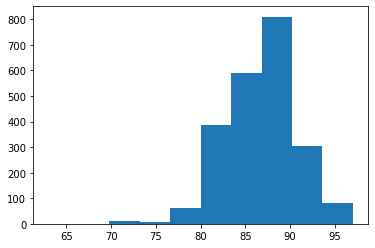

In [5]:
plt.hist(data["review.point"])
plt.savefig('reviewpoints.png')

In [6]:
training_data = data["description"]  # just keep description
training_data = training_data.str.findall(r"[\w]+|[''.,!?;]")  # split words and punctuations (tokens)
training_data

0       [Magnificently, powerful, and, intense, ., Car...
1       [What, impresses, me, most, is, how, this, whi...
2       [There, have, been, some, legendary, Bowmores,...
3       [With, a, name, inspired, by, a, 1926, Buster,...
4       [Captivating, ,, enticing, ,, and, wonderfully...
                              ...                        
2242    [Its, best, attributes, are, vanilla, ,, toast...
2243    [Aged, in, a, sherry, cask, ,, which, adds, sw...
2244    [Earthy, ,, fleshy, notes, with, brooding, gra...
2245    [The, sherry, is, very, dominant, and, cloying...
2246    [Fiery, peat, kiln, smoke, ,, tar, ,, and, rip...
Name: description, Length: 2247, dtype: object

In [7]:
# flatten
vocab = [token for review in training_data for token in review]

In [8]:
# create mapping from tokens to integer; and vice versa.
dictionary = {}

# list of tuples (tokens, freq).
# Using Counter.most_common ensures that the mapping of the tokens is deterministic 
tokens_counts = Counter(vocab).most_common() 

# dictionary of token:int
for i in range(len(tokens_counts)):
    dictionary[tokens_counts[i][0]] = i

# reverse dictionary of int:token
reverse_dictionary = {v: k for k, v in dictionary.items()}

In [9]:
# turn list of tokens to a list of numbers
def tokens_to_ids(tokens):
    return list(map(dictionary.get, tokens))

# turn list of numbers into a list of tokens
def ids_to_tokens(ids):
    return list(map(reverse_dictionary.get, ids))

# turn list of tokens into string
def tokens_to_string(tokens):
    out = ""
    
    for token in tokens:
        if any(p in token for p in punctuation):
            out = out + token
        elif not out or (out[-1] in [".", ";"]):
                out = out + " " + token.capitalize()
        else:
            out = out + " " + token.lower()
    
    # add ! or . randomly at the end
    if out[-1] not in punctuation:
        exclam = choices([0,1])[0]
        if exclam:
            out = out + "!"
        else:
            out = out + "."
            
    return out.strip()

### Create Training Set

Create the training set by randomly picking sequences of tokens from our dataset of reviews.

In [10]:
# number of training samples
n_train_samples = 50000 

# length of sequence: this will be length of the training sequence plus one (prediction)
sequence_length = 5

X_train = []
y_train = []

In [8]:
def review_to_sample(review, sequence_length):
    sequence_start = randrange(len(review) - sequence_length)
    sequence_end = sequence_start + sequence_length
    sequence = review[sequence_start:sequence_end]
    sequence = tokens_to_ids(sequence)
    
    input_sequence = sequence[:-1]
    target = sequence[-1]
    
    return input_sequence, target

In [9]:
training_data = training_data.loc[training_data.str.len() >= sequence_length]
vocab_ids = []

for i in range(n_train_samples):
    review = training_data.sample(1).reset_index(drop = True)[0]
    new_input, new_target = review_to_sample(review, sequence_length)
    X_train.append(new_input)
    y_train.append(new_target)
    
    # keep track of vocabulary in training set
    vocab_ids = vocab_ids + np.unique(new_input).tolist() + [new_target]

vocab_size = len(set(vocab_ids))

In [10]:
X_train = np.reshape(X_train, (n_train_samples, sequence_length - 1, 1))
y_train = tf.keras.utils.to_categorical(y_train)

### Model

LSTM with dropout to prevent overfitting.

In [11]:
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation = "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = "adam")

In [12]:
model.fit(X_train, y_train, epochs = 50, batch_size = 128)

Epoch 1/50
391/391 [==============================] - 34s 86ms/step - loss: 6.2148
Epoch 2/50
391/391 [==============================] - 35s 90ms/step - loss: 5.6730
Epoch 3/50
391/391 [==============================] - 34s 86ms/step - loss: 5.4773
Epoch 4/50
391/391 [==============================] - 33s 85ms/step - loss: 5.3276
Epoch 5/50
391/391 [==============================] - 33s 85ms/step - loss: 5.1927
Epoch 6/50
391/391 [==============================] - 34s 88ms/step - loss: 5.0665
Epoch 7/50
391/391 [==============================] - 37s 95ms/step - loss: 4.9611
Epoch 8/50
391/391 [==============================] - 38s 96ms/step - loss: 4.8498 0s - loss: 4.
Epoch 9/50
391/391 [==============================] - 39s 99ms/step - loss: 4.7454
Epoch 10/50
391/391 [==============================] - 38s 98ms/step - loss: 4.6503
Epoch 11/50
391/391 [==============================] - 37s 95ms/step - loss: 4.5620
Epoch 12/50
391/391 [==============================] - 37s 95ms/step - 

In [13]:
model.save('mainmodel2')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: mainmodel2\assets


### Generate Text

It's possible to add more randomness using temperature, but I found that the output becomes too random.

In [11]:
model = tf.keras.models.load_model('mainmodel2')

In [12]:
# given vector, choose next id stochastically.
def vector_to_prediction(vector):
    weights = vector.flatten().tolist()
    pred = choices(population = list(range(len(weights))), weights = weights)
    
    return pred[0]

In [13]:
training_data.str.len().describe() # data on the length of reviews

count    2247.000000
mean       87.597241
std        24.921484
min         2.000000
25%        76.000000
50%        87.000000
75%        96.000000
max       270.000000
Name: description, dtype: float64

In [108]:
# how long text to generate
# for simplicity just use uniform distribution on the IQR of training set review lengths.
gen_length = choices(range(76,96))[0] 

# initialize random sequence of first words; 
# choose a number that is less than the existing vocabulary size if loading model
# if model trained in current session, use vocab_size.
curr_sequence = choices(range(5000), k = sequence_length - 1) 
gen_length = gen_length - len(curr_sequence)

for i in range(gen_length):   
    input_sequence = np.array(curr_sequence[-(sequence_length - 1):]).reshape(1, sequence_length - 1, 1)
    output_vec = model.predict(input_sequence)
    curr_sequence.append(vector_to_prediction(output_vec)) 
    
# fake review
tokens_to_string(ids_to_tokens(curr_sequence))

'Filtration layered rarer plant, rather, smoky, with cocoa apples freshly and caramel distilled. Vanilla, flowery forward, and a whiff. A shows expression. Honey expression, with soft white fragrant in a limited pipe when is company and matured. The palate initially robust! to the best palate, which ultimately emerge caol several. A smoke oily of honey initially fill to the end palate, which ultimately, toasted vanilla, blonde of flavor casks.'

In [35]:
# example of a real review
data["description"].sample(1).reset_index(drop=True)[0]

'This 1980 expression of The Dalmore Constellation has been solely matured in a Gonzales Byass Apostoles oloroso sherry butt. The resultant whisky is sweet on the nose, with dates, figs, milk chocolate-covered caramel, and finally a suggestion of eucalyptus. Briefly fruity on the palate, becoming bitter, with dark coffee notes. Long and spicy in the finish, with black pepper and licorice. Cask number 2140; 227 bottles. '